In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time  # Import the time module

# System Parameters (SI units)
max_head = 571.0  # Maximum head (elevation difference) [m]
max_volume = 7682000  # [m3]
reservoir_area = 670000.0  # Reservoir area [m^2]
max_level_change = max_volume / reservoir_area  # Maximum water level change [m]
gravity = 9.81  # Acceleration due to gravity [m/s^2]
water_density = 1000.0  # Density of water [kg/m^3]
efficiency_pump = 0.9  # Pump efficiency
efficiency_turbine = 0.9  # Turbine efficiency
max_power_turbine = 135e6  # Maximum generating power [W] (135MW)
max_flow_rate = 33.0  # Maximum flow rate [m^3/s]
min_level = 2  # Minimum level allowed in the reservoir [m]


# Derivation of max power pump
max_power_pump = (water_density * gravity * max_flow_rate * max_head) / efficiency_pump  # [W]

# Time parameters
hours_per_day = 24
days_per_month = 30  # Assuming 30 days for simplicity
days_per_year = 365
hours_per_year = hours_per_day * days_per_year
time_step = 1  # 1-hour time steps



def generate_energy_prices(T, base_price=50, peak_amplitudes=[10,15], peak_times=[8, 18], std_dev=5, long_term_variation_amplitude=10, period=120*24):
    """
    Generate a realistic daily electricity price trend with two peaks and stochastic variations,
    plus a long-term sinusoidal variation.

    Parameters:
        T (int): Number of time steps (e.g., hours).
        base_price (float): Average electricity price ($/MWh).
        peak_amplitudes (list): Amplitudes of price fluctuations due to demand.
        peak_times (list): List of peak electricity price hours (e.g., [8, 18] for morning and evening peaks).
        std_dev (float): Standard deviation for stochastic variations.
        long_term_variation_amplitude (float): Amplitude of the long-term price variation.
        period (int): Period of the long-term variation in hours (e.g., 30*24 for monthly).

    Returns:
        np.array: Simulated electricity prices over time.
    """
    time = np.arange(T)

    # Sum of two sinusoidal functions for morning and evening peaks
    prices = (base_price
              + peak_amplitudes[0] * -np.sin((time - peak_times[0]) * np.pi / 6)
              + peak_amplitudes[1] * -np.sin((time - peak_times[1]) * np.pi / 12))

    # Add stochastic noise
    prices += np.random.normal(0, std_dev, T)

    # Add long-term sinusoidal variation
    prices += long_term_variation_amplitude * np.sin(2 * np.pi * time / period)
    return prices



def generate_hourly_flows(T, base_inflow = 5, base_std = 0.75, avg_extra = 5, rain_prob = 0.03, extra_std = 1):
    """
    Generate stochastic basin inflows over a given time horizon with seasonal variability.

    Parameters:
        T (int): Number of time steps.
        base_inflow (float): Average base inflow (MWh per time step).
        base_std (float): Standard deviation for the base inflow.
        avg_extra (float): Average extra inflow due to rainfall.
        rain_prob (float): Probability of extra rainfall inflow.
        extra_std (float): Standard deviation for the extra inflow from rainfall.

    Returns:
        np.array: Stochastic basin inflow series (MWh per time step).
    """
    time = np.arange(T)
    hours_in_year = 8760  # typical non-leap year
    # Spring peak at ~day 80-172 → max around day 100 → hour 2400
    # Seasonal multiplier: peak = 1.3, trough = 0.7
    seasonal_factor = 1 + 0.3 * np.sin(2 * np.pi * time / hours_in_year - np.pi/2)  # peak in spring

    base = np.random.normal(base_inflow, base_std, T) * seasonal_factor
    base = np.clip(base, 0, None)

    rain_events = np.random.binomial(1, rain_prob, T)
    extra = rain_events * np.random.normal(avg_extra, extra_std, T)
    extra = np.clip(extra, 0, None)

    return base + extra
    
def evaporation_loss(T, avg_evap = 0, peak_amplitude = 0.5):
    """
    Generate an approximation of evaporation loss with seasonal variability.

    Parameters:
        T (int): Number of time steps.
        avg_evap (float): Average daily evaporation loss per hour (MWh).
        peak_time (int): Hour of maximum daily evaporation.
        peak_amplitude (float): Additional evaporation at peak hour.

    Returns:
        np.array: Hourly evaporation loss.
    """
    time = np.arange(T)
    hours_in_year = 8760
    # Summer peak → max around mid-year (~day 180) → hour ~ 4320
    seasonal_factor = 1 + 0.3 * np.sin(2 * np.pi * time / hours_in_year)  # peak in summer

    # Daily variation (e.g. more during day than night)
    daily_hours = time % 24
    daily_cycle = avg_evap + peak_amplitude * np.sin((np.pi / 12) * (daily_hours - 12))

    evap = daily_cycle * seasonal_factor
    evap = np.clip(evap, 0, None)

    return evap



inflow_series = 3600 * (generate_hourly_flows(hours_per_year) - evaporation_loss(hours_per_year))

# Use the function to generate price series.
price_series = generate_energy_prices(hours_per_year)


# Initial reservoir level
initial_level = min_level + max_level_change / 2  # [m]


def calculate_power(level, is_generating):
    """
    Calculates power generated or consumed, accounting for head and max flow rate.

    Args:
        level: Current water level [m].
        is_generating: Boolean, True if generating, False if pumping.

    Returns:
        Power [W].
    """
    head = max_head - level
    if head <= 0:
        return 0.0

    available_flow_rate = level * reservoir_area / (time_step * 3600)  # m^3/s
    flow_rate = min(available_flow_rate, max_flow_rate)  # Limit the flow rate.

    if is_generating:
        power = efficiency_turbine * water_density * gravity * head * flow_rate
        return min(power, max_power_turbine)  # Limit to max turbine power
    else:
        power = (water_density * gravity * head * flow_rate) / efficiency_pump
        return min(power, max_power_pump)  # Limit to max pump power



def optimize_storage(price_series, inflow_series, initial_level):
    """
    Optimizes the operation of the pumped hydro storage system for one year,
    enforcing that the final water level is the same as the initial level.

    Args:
        price_series: Array of electricity prices for each hour of the year (€/MWh).
        initial_level: Initial water level in the reservoir [m].

    Returns:
        tuple: (actions, profits, levels, volumes)
            actions: Array of actions (1=generate, -1=pump, 0=do nothing)
            profits: Array of profits for each hour.
            levels: Array of water levels
            volumes: Array of water volumes
    """
    num_steps = len(price_series)
    levels = np.zeros(num_steps + 1)
    levels[0] = initial_level
    actions = np.zeros(num_steps)
    profits = np.zeros(num_steps)
    volumes = np.zeros(num_steps + 1)
    volumes[0] = initial_level * reservoir_area
    final_level = initial_level #target



    for t in range(num_steps):
        current_level = levels[t]
        price = price_series[t]
        inflow = inflow_series[t]

        # 1. Determine optimal action:
        #    - Generate if price is high, pump if price is low.
        if price > np.mean(price_series)-0.2*np.mean(price_series):  # Simplified decision-making
            action = 1  # Generate
        elif price < np.mean(price_series)-0.2*np.mean(price_series):
            action = -1  # Pump
        else:
            action = 0  # Do nothing

        # 2. Calculate power and level/volume change:
        if action == 1:  # Generate
            power = calculate_power(current_level, True)
            volume_change = -power * time_step * 3600 / (water_density * gravity * (max_head - current_level))
        elif action == -1:  # Pump
            power = calculate_power(current_level, False)
            volume_change = power * time_step * 3600 / (water_density * gravity * (max_head - current_level))
        else:
            power = 0
            level_change = 0

        # 3. Enforce physical constraints:
        new_volume = volumes[t] + volume_change + inflow
        new_level = new_volume / reservoir_area
        
        if new_level > min_level + max_level_change:
            new_level = min_level + max_level_change
            new_volume = new_level * reservoir_area
            if action == 1:
                volume_change = (new_level - current_level) * reservoir_area
                power = - volume_change * water_density * gravity * (
                        max_head - current_level) / (time_step * 3600 * efficiency_turbine)
            elif action == -1:
                volume_change = (new_level - current_level) * reservoir_area
                power = volume_change * water_density * gravity * (
                        max_head - current_level) / (time_step * 3600 * efficiency_pump)
        elif new_level < min_level:
            new_level = min_level
            new_volume = new_level * reservoir_area
            if action == 1:
                volume_change = (new_level - current_level) * reservoir_area
                power = - volume_change * water_density * gravity * (
                        max_head - current_level) / (time_step * 3600 * efficiency_turbine)
            elif action == -1:
                volume_change = (new_level - current_level) * reservoir_area
                power = volume_change * water_density * gravity * (
                        max_head - current_level) / (time_step * 3600 * efficiency_pump)
        levels[t + 1] = new_level
        volumes[t + 1] = new_volume 
        actions[t] = action
        if action == 1:
            profits[t] = (power / 1e6) * price  # Revenue (€) for MWh
        else:
            profits[t] = -(power / 1e6) * price / 2  # cost to pump, assumed half of revenue,  (€) for MWh
    # Adjust the last day to meet the final level constraint
    last_day_start = (days_per_year - 1) * hours_per_day
    level_diff = final_level - levels[last_day_start]
    if abs(level_diff) > 1e-3:  #tol
        volume_change = level_diff * reservoir_area
        avg_power = volume_change * water_density * gravity * max_head / (hours_per_day * 3600)
        if level_diff > 0: #need to pump
            avg_power = avg_power / efficiency_pump
            for t in range(last_day_start, num_steps):
                if price_series[t] > np.mean(price_series): #if price is high, better to reduce generation
                    actions[t] = -1
                    profits[t] = -(avg_power / 1e6) * price_series[t] / 2
                else:
                    actions[t] = -1
                    profits[t] = -(avg_power / 1e6) * price_series[t] / 2
        else: #need to generate
             avg_power =  avg_power * efficiency_turbine
             for t in range(last_day_start, num_steps):
                if price_series[t] < np.mean(price_series):
                    actions[t] = 1
                    profits[t] = (avg_power/1e6) * price_series[t]
                else:
                    actions[t] = 1
                    profits[t] = (avg_power / 1e6) * price_series[t]
    return actions, profits, levels[:-1], volumes[:-1]


# Record the start time
start_time = time.time()

# Run the optimization
optimized_actions, optimized_profits, optimized_levels, optimized_volumes = optimize_storage(price_series,inflow_series, initial_level)

# Record the end time
end_time = time.time()

# Calculate the duration
duration = end_time - start_time

# Print Results
total_revenue = np.sum(optimized_profits)
daily_revenue = np.sum(optimized_profits) / days_per_year
print(f"Total Revenue for the year: €{total_revenue:.2f}")
print(f"Average Daily Revenue: €{daily_revenue:.2f}")
print(f"Optimization took {duration:.2f} seconds")  # Print the duration

Total Revenue for the year: €27936437.79
Average Daily Revenue: €76538.19
Optimization took 1.18 seconds


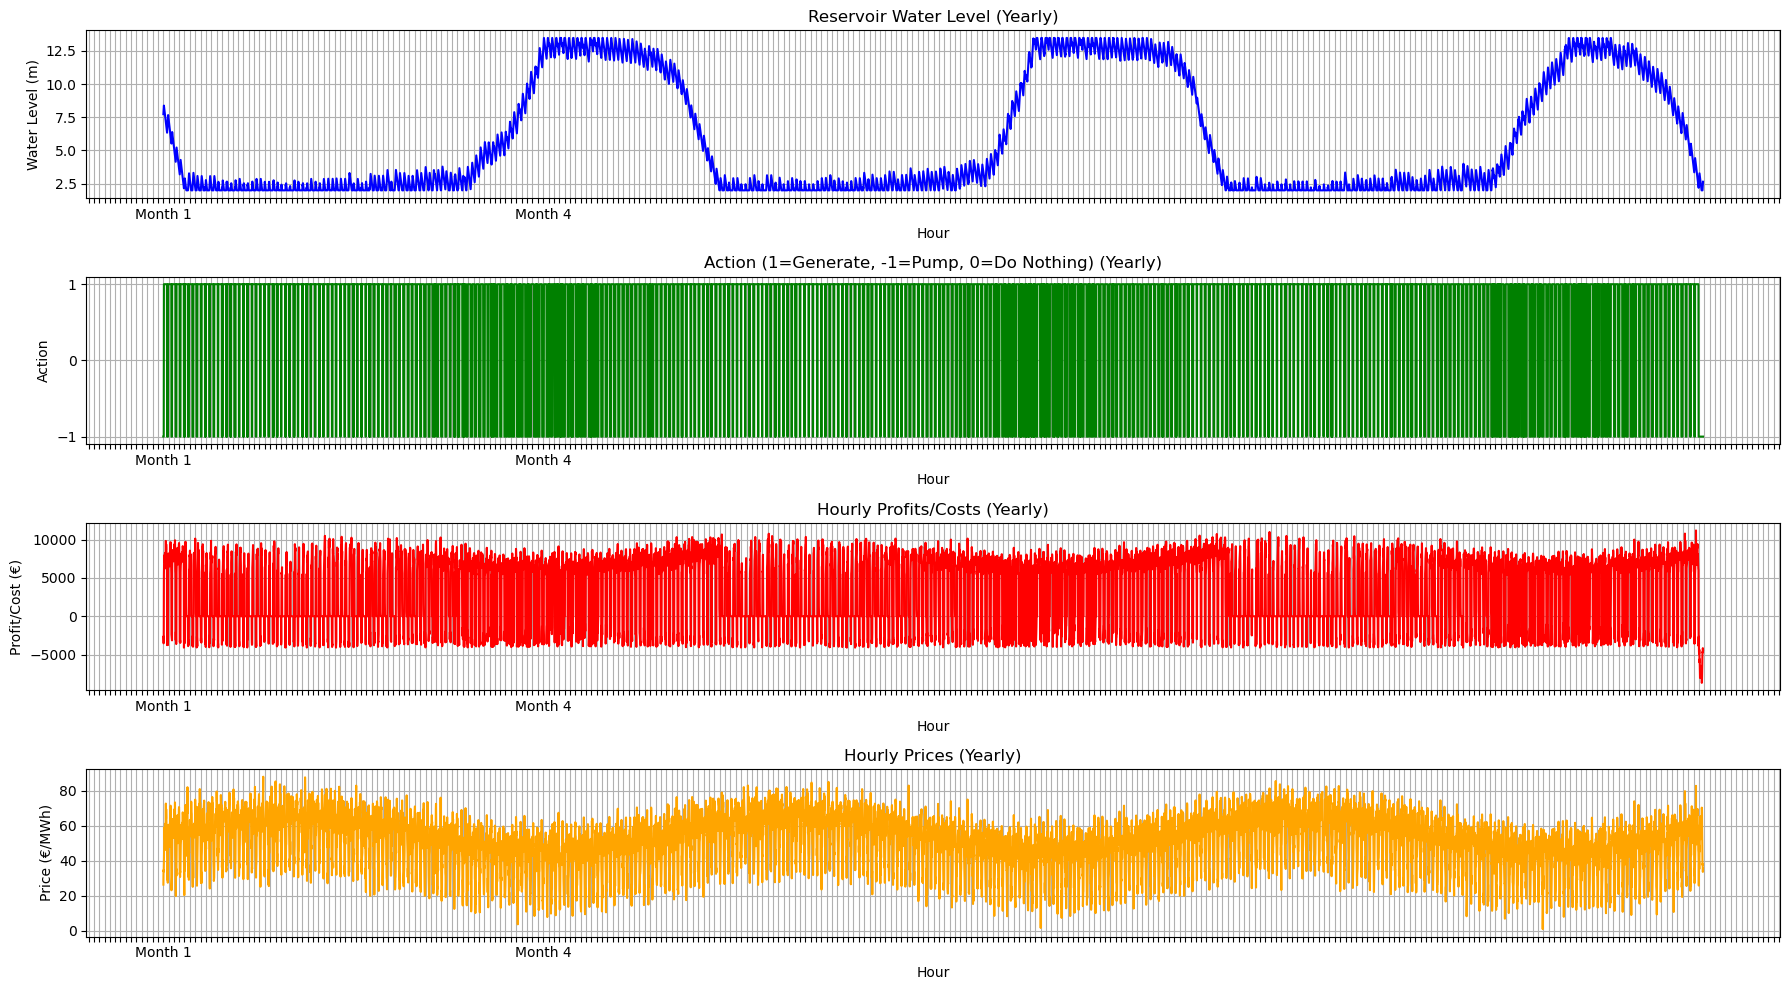

In [27]:
def plot_results(levels, actions, profits, price_series, volumes):
    """
    Plots the results of the pumped hydro storage optimization using line plots.

    Args:
        levels: Array of water levels for each hour.
        actions: Array of actions (1=generate, -1=pump, 0=do nothing)
        profits: Array of profits for each hour.
        price_series: Array of electricity prices.
        volumes: array of water volumes
    """
    hours = np.arange(len(levels))
    days = np.arange(0, len(levels), 24)  # Mark the start of each day
    months = np.arange(0, len(levels), 24 * 30)  # Mark the start of each month

    plt.figure(figsize=(18, 10))

    plt.subplot(4, 1, 1)
    plt.plot(hours, levels, color='blue')
    plt.xlabel("Hour")
    plt.ylabel("Water Level (m)")
    plt.title("Reservoir Water Level (Yearly)")
    plt.grid(True)
    plt.xticks(months, [f"Month {i + 1}" for i in range(13)])  # Corrected x-ticks
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator()) #Added

    plt.subplot(4, 1, 2)
    plt.plot(hours, actions, color='green')
    plt.xlabel("Hour")
    plt.ylabel("Action")
    plt.title("Action (1=Generate, -1=Pump, 0=Do Nothing) (Yearly)")
    plt.yticks([-1, 0, 1])
    plt.grid(True)
    plt.xticks(months, [f"Month {i + 1}" for i in range(13)]) # Corrected x-ticks
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator()) #Added

    plt.subplot(4, 1, 3)
    plt.plot(hours, profits, color='red')
    plt.xlabel("Hour")
    plt.ylabel("Profit/Cost (€)")
    plt.title("Hourly Profits/Costs (Yearly)")
    plt.grid(True)
    plt.xticks(months, [f"Month {i + 1}" for i in range(13)]) # Corrected x-ticks
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator()) #Added

    plt.subplot(4, 1, 4)
    plt.plot(hours, price_series, color='orange')
    plt.xlabel("Hour")
    plt.ylabel("Price (€/MWh)")
    plt.title("Hourly Prices (Yearly)")
    plt.grid(True)
    plt.xticks(months, [f"Month {i + 1}" for i in range(13)]) # Corrected x-ticks
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator()) #Added

    plt.tight_layout()
    plt.show()
# Plot the results
plot_results(optimized_levels, optimized_actions, optimized_profits, price_series, optimized_volumes)